# GAN Monet Stylized Photos

### Project Introduction

#### Transforming Photos into Monet-Style Paintings Using Deep Learning

The goal of this project is to develop a deep learning model capable of transforming real-world photos into images styled after the works of Claude Monet. Using neural networks, the project uses CycleGANs, to bridge the stylistic gap between two distinct domains: **Monet Paintings** and **Photos**.


In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np
import tensorflow_addons as tfa


/home/sangelov/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/sangelov/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

## Data

The Kaggle challenge provides two separate datasets: Monet Paintings and Photos. Both datasets are encoded as tensorflow datasets.

Monet Paintings Dataset:
- 300 Monet Paintings that are 256 x 256 pixles and 3 color channels
- To be used as a reference for the style the model should learn.

Photo Dataset:
- 7028 Photos that are 256 x 256 pixels with 3 color channels. 
- To be stylized photos, that will receive the Monet style. These photos are uploaded to Kaggle to be graded.





## EDA

To start off, let's just examine a few of the Monet paintings, and a few of the photos to be stylized:

In [2]:
MONET_TFREC_FILENAMES = tf.io.gfile.glob('./data/monet/*.tfrec')
PHOTO_TFREC_FILENAMES = tf.io.gfile.glob('./data/photos/*.tfrec')


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # Converts image to range [-1, 1]
    return image


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset



monet_dataset = load_dataset(MONET_TFREC_FILENAMES).shuffle(300).batch(1)
photos_dataset = load_dataset(PHOTO_TFREC_FILENAMES).shuffle(300).batch(1)





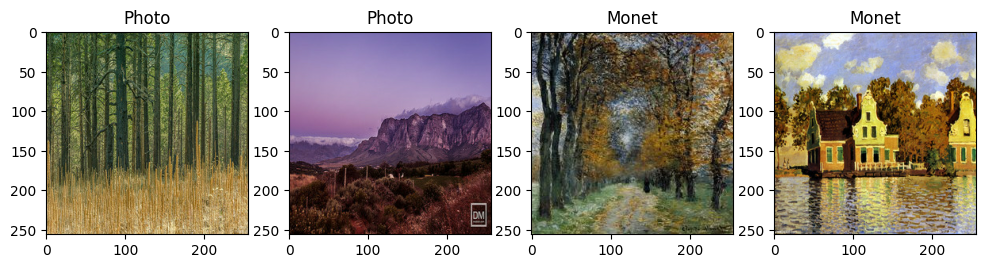

In [3]:
# Show some example photos
monet_iter = iter(monet_dataset)
photos_iter = iter(photos_dataset)

plt.figure(figsize=(12, 8))
plt.subplot(141)
plt.title('Photo')
plt.imshow(next(photos_iter)[0] * 0.5 + 0.5)

plt.subplot(142)
plt.title('Photo')
plt.imshow(next(photos_iter)[0] * 0.5 + 0.5)

plt.subplot(143)
plt.title('Monet')
plt.imshow(next(monet_iter)[0] * 0.5 + 0.5)

plt.subplot(144)
plt.title('Monet')
plt.imshow(next(monet_iter)[0] * 0.5 + 0.5)




Monet paintings are very stylized, and as such I'm wondering if there is a certain color skew to them that is different than the photos. Photos taken under white light (like the sun) often can follow the gray-world assumption, ie colors are roughly equaly represented. To investigate this I'm going to visualize the photos and paintings in a 3D colorspace. I'll do 3 plots each of red-green, green-blue, and blue-red distributions, where each point on the plot will represent the mean values for a given sample. 

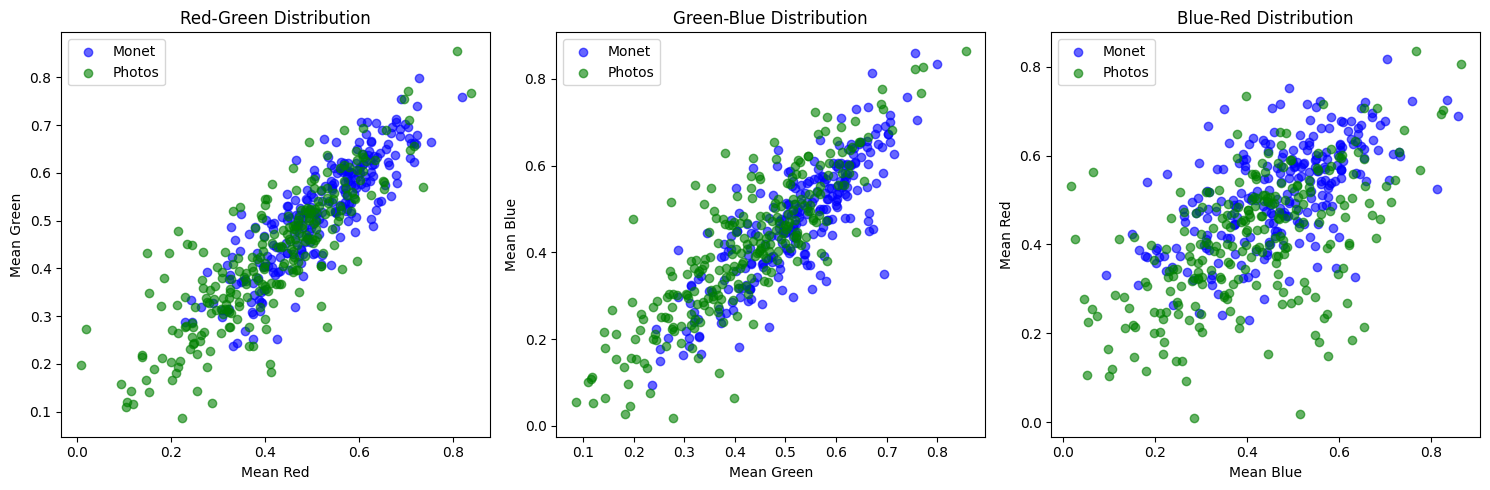

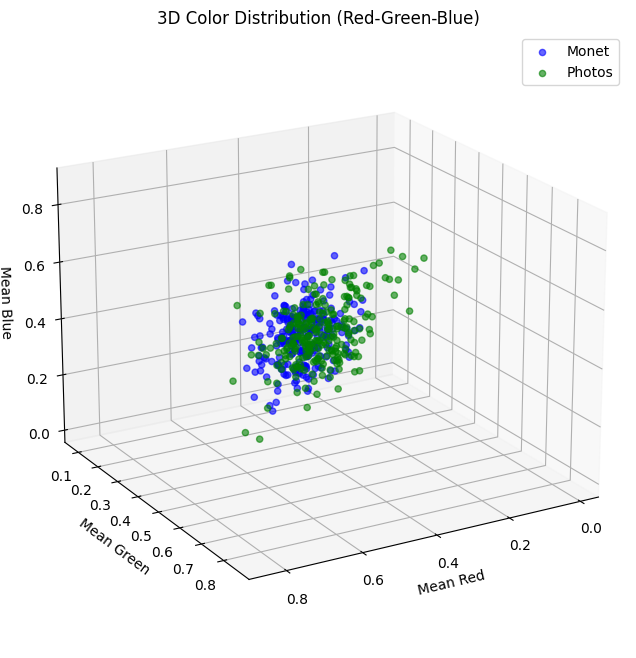

In [38]:
# Mean Colors Calculation Distributions 
def calculate_channel_means(image_iterator, samples = 250 // 1):

    image_iterator = islice(image_iterator, samples)

    r_means, g_means, b_means = [], [], []
    for images in image_iterator:
        for image in images:
            img = image * 0.5 + 0.5
            r_means.append(np.mean(img[:, :, 0]))
            g_means.append(np.mean(img[:, :, 1]))
            b_means.append(np.mean(img[:, :, 2]))
    return r_means, g_means, b_means


monet_means_r, monet_means_g, monet_means_b = calculate_channel_means(monet_iter)
photo_means_r, photo_means_g, photo_means_b = calculate_channel_means(photos_iter)



plt.figure(figsize=(15, 5))

# Red-Green distribution
plt.subplot(1, 3, 1)
plt.scatter(monet_means_r, monet_means_g, alpha=0.6, c='blue', label='Monet')
plt.scatter(photo_means_r, photo_means_g, alpha=0.6, c='green', label='Photos')
plt.xlabel('Mean Red')
plt.ylabel('Mean Green')
plt.title('Red-Green Distribution')
plt.legend()

# Green-Blue distribution
plt.subplot(1, 3, 2)
plt.scatter(monet_means_g, monet_means_b, alpha=0.6, c='blue', label='Monet')
plt.scatter(photo_means_g, photo_means_b, alpha=0.6, c='green', label='Photos')
plt.xlabel('Mean Green')
plt.ylabel('Mean Blue')
plt.title('Green-Blue Distribution')
plt.legend()

# Blue-Red distribution
plt.subplot(1, 3, 3)
plt.scatter(monet_means_b, monet_means_r, alpha=0.6, c='blue', label='Monet')
plt.scatter(photo_means_b, photo_means_r, alpha=0.6, c='green', label='Photos')
plt.xlabel('Mean Blue')
plt.ylabel('Mean Red')
plt.title('Blue-Red Distribution')
plt.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Monet data points
ax.scatter(monet_means_r, monet_means_g, monet_means_b, alpha=0.6, c='blue', label='Monet')

# Photo data points
ax.scatter(photo_means_r, photo_means_g, photo_means_b, alpha=0.6, c='green', label='Photos')

ax.view_init(elev=20.1, azim=60)

# Labels and title
ax.set_xlabel('Mean Red')
ax.set_ylabel('Mean Green')
ax.set_zlabel('Mean Blue')
ax.set_title('3D Color Distribution (Red-Green-Blue)')

# Legend
ax.legend()

# Show plot
plt.show()













To me this does show a slight variation in the average brightnesses between the 3 color channels when comparing the Monet paintings to real photos. It does seem like Monet slightly exagerates the reds and greens in his paintings, as well as just having more overall brightness. An interesting observation here is how the graphs for red-green, and green-blue are closer to a y=x plot. The blue-red plot has a bit more variation, but it generaly follows the same principle. The variation might be due to the more limited presence of magenta-type colors in nature. Regardless this exercise is representitive of two types of photo distributions, and may be one way our model tries to discriminate, or generate our stylezed photos. 

## Architecture

To start off, I'll follow along with Jonathan Hui's CycleGAN article and model found [here](https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7). This was provided as a class resource. The model has three distinct networks and is designed as follows:

- **Generator G**: Converts a real image (domain X) to a Monet-style image (domain Y).
- **Generator F**: Converts a Monet painting (domain Y) to a real image (domain X).
- **Discriminator D_Y**: Takes an input from domain Y and decides if it is a real Monet painting or one generated by **G**.
- **Discriminator D_X**: Takes an input from domain X and decides if it is a real photo or one generated by **F**.

CycleGAN has three separate loss functions combined to give the total loss:
- **Two Adversarial Losses**: One for each discriminator-generator pair.
- **Cycle Consistency Loss**: Ensures that \( x \to y \to x \) and \( y \to x \to y \) transformations have minimal loss.
- **Identity Loss**: Ensures that G(y) -> y. ie if the image is already in the transformation domain, no change will be made to the image

Generators and discriminators can be somewhat interchanged. However, GANs often have training challenges, such as vanishing/exploding gradients and mode collapse. Using established network architectures for these components can help ensure some degree of success. I will model my generators and discriminators after pre-existing networks to explore how performance changes with different architectures.

---

### Generators

For my two separate models, I will alter the **generators** while keeping the **discriminators** the same. The generator models I will explore are:
1. **U-Net**
2. **C-CAN** (the architecture used in "Unpaired Image-to-Image Translation Using Cycle-Consistent Adversarial Networks").

#### **U-Net**
U-Net's architecture resembles an encoder-decoder structure:
- **Encoder**: Downsamples the input.
- **Decoder**: Upsamples the representation back to the desired output.
- **Skip Connections**: Help propagate signals forward and backward through the network, mitigating vanishing/exploding gradients.

Each encoder layer uses **LeakyReLU** activation, while the decoder layers use **ReLu** for all layers except for the final layer, which uses the **tanh** activation function. The implementation is based on [this Kaggle notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook). This will serve as the baseline for comparing the C-CAN network.

##### **Network Architecture**
- **Downsample Layer (down)**: `Conv2D(filters, size, instanceNorm, strides=2, padding='same', activation=LeakyReLU)`
- **Upsample Layer (up)**: `Conv2D(filters, size, instanceNorm, strides=2, padding='same', activation=ReLU)`

Each downsample layer connects to its corresponding upsample layer via skip connections.

```text
down(64, 4, False) = skip1
down(128, 4, True) = skip2
down(256, 4, True) = skip3
down(512, 4, True) = skip4
down(512, 4, True) = skip5
down(512, 4, True) = skip6
down(512, 4, True) = skip7
down(512, 4, True)
up(512, 4, True) + skip7
up(512, 4, True) + skip6
up(512, 4, True) + skip5
up(512, 4, True) + skip4
up(256, 4, True) + skip3
up(128, 4, True) + skip2
up(64, 4, True) + skip1
Conv2DTranspose(filters=3, size=4, strides=2, padding='same', activation=tanh)
```


---

#### **C-CAN**
C-CAN (Cycle-Consistent Adversarial Networks) employs a different generator architecture. This model, introduced in the paper that produced the famous horse-to-zebra mappings, utilizes **9 residual blocks**. Residual blocks incorporate skip connections and are modeled as:

\[
F(x) + x
\]

Where \( x \) is the input to the block, and \( F() \) is the function modeled by the block's weights.

##### **Network Architecture**
- **Convolutional Layers**:
  - `Conv(filters=64, size=7, stride=1, instanceNorm=True, activation=ReLU)`
  - `down(128, 3, activation=ReLU, padding='reflection')`
  - `down(256, 3, activation=ReLU, padding='reflection')`
- **Residual Blocks** (9 blocks):
  - Each block maintains the same number of filters (256). Each residual block is essentially two Conv2D blocks with 256 filters, but the input is added to the output before passing to the next block.
- **Upsample Layers**:
  - `up(128, 3, True)`
  - `up(64, 3, True)`
- **Final Convolution Layer**:
  - `Conv(filters=3, size=7, stride=1, instanceNorm=True, activation=tanh)`

This model is simpler than more modern architectures but is a good candidate for comparison with U-Net.

---


In [5]:

class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')


class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')
        self.norm1 = tfa.layers.InstanceNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')
        self.norm2 = tfa.layers.InstanceNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        return x + inputs  # Skip connection


def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def UNetGenerator(name):
    with tf.name_scope(name):
        inputs = tf.keras.layers.Input(shape=[256,256,3])

        # bs = batch size
        down_stack = [
            downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
            downsample(128, 4), # (bs, 64, 64, 128)
            downsample(256, 4), # (bs, 32, 32, 256)
            downsample(512, 4), # (bs, 16, 16, 512)
            downsample(512, 4), # (bs, 8, 8, 512)
            downsample(512, 4), # (bs, 4, 4, 512)
            downsample(512, 4), # (bs, 2, 2, 512)
            downsample(512, 4), # (bs, 1, 1, 512)
        ]

        up_stack = [
            upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            upsample(512, 4), # (bs, 16, 16, 1024)
            upsample(256, 4), # (bs, 32, 32, 512)
            upsample(128, 4), # (bs, 64, 64, 256)
            upsample(64, 4), # (bs, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        last = tf.keras.layers.Conv2DTranspose(3, 4,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    activation='tanh') # (bs, 256, 256, 3)

        x = inputs

        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])

        x = last(x)

        return tf.keras.Model(inputs=inputs, outputs=x)


def CCanGenerator(name):
    with tf.name_scope(name):
        inputs = tf.keras.layers.Input(shape=[256,256,3])
        
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(256, 256, 3)),
            tf.keras.layers.Conv2D(64, 7, strides=1, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),

            ReflectionPadding2D(),
            tf.keras.layers.Conv2D(128, 3, strides=2, padding='valid', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),
            ReflectionPadding2D(),
            tf.keras.layers.Conv2D(256, 3, strides=2, padding='valid', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),

            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
            tfa.layers.InstanceNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(3, 7, strides=1, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
            tfa.layers.InstanceNormalization(),
        ])




        outputs = model(inputs)

        return tf.keras.Model(inputs=inputs, outputs=outputs)




#### Descriminators

The descriminator network will be modelled after PatchGAN, which classifies small parts of the input image as either real or fake. Each of these patches is outputed as a value in a matrix, where lower values indicate a fake image, and higher values indicate a real image - ie a matrix with all ones would indicate the descriminator thinks each patch of the input image is a perfect representation of a real image. 

In [6]:
def PatchDescriminator(name):
    with tf.name_scope(name):
        initializer = tf.random_normal_initializer(0., 0.02)

        # Input layer
        inp = tf.keras.layers.Input(shape=[256, 256, 3])
        x = inp

        # Convolutional layers
        x = tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer)(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        x = tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        x = tf.keras.layers.Conv2D(256, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        x = tf.keras.layers.Conv2D(512, kernel_size=4, strides=1, padding='same', kernel_initializer=initializer)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        # Output layer
        x = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same', kernel_initializer=initializer, activation='sigmoid')(x)

        return tf.keras.Model(inputs=inp, outputs=x)



For their respective initializations, we can take a look at what the C-CAN and U-NET generators produce as 'Monet' images without any training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


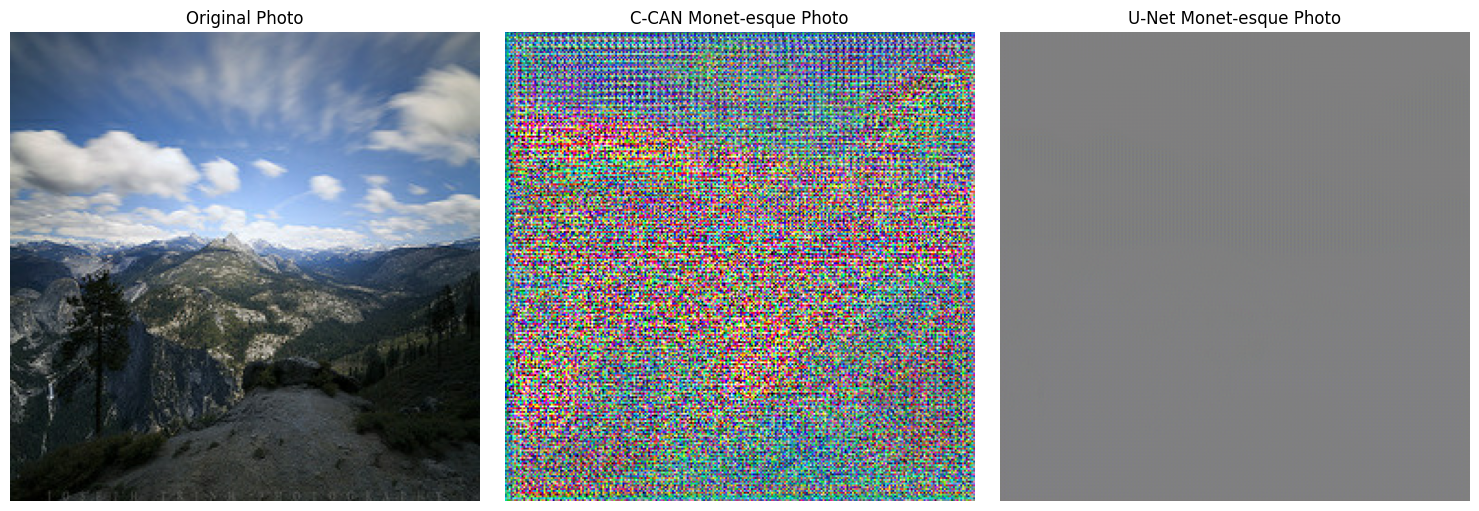

In [7]:

monet_unet_generator = UNetGenerator('umonetg') # transforms photos to Monet-esque paintings
photo_unet_generator = UNetGenerator('uphotog') # transforms Monet paintings to be more like photos

monet_ccan_generator = CCanGenerator('cmonetg')
photo_ccan_generator = CCanGenerator('cphotog')


monet_ccan_discriminator = PatchDescriminator('cmonetd') # differentiates real Monet paintings and generated Monet paintings
photo_ccan_discriminator = PatchDescriminator('cphotod')

monet_unet_discriminator = PatchDescriminator('umonetd') # differentiates real Monet paintings and generated Monet paintings
photo_unet_discriminator = PatchDescriminator('uphotod')


photo_example = next(photos_iter)[0]
# Add batch dimension to make it (1, 256, 256, 3)
photo_example = tf.expand_dims(photo_example, axis=0)


to_monet_unet = monet_unet_generator(photo_example)
tp_monet_ccan = monet_ccan_generator(photo_example)


plt.figure(figsize=(15, 5))  # Set figure size to make subplots more readable


plt.subplot(1, 3, 1)
plt.title("Original Photo")
plt.imshow(photo_example[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("C-CAN Monet-esque Photo")
plt.imshow(tp_monet_ccan[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("U-Net Monet-esque Photo")
plt.imshow(to_monet_unet[0] * 0.5 + 0.5)
plt.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display all subplots in one figure









Next I'll start with the CycleGAN implementation. This basically defines the Model + it's training step. This implementation is based off of the [this Kaggle notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook)

In [8]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=5,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            total_monet_identity_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle * .5)


            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle) # Original Paper uses 1/2 of cycle lambda
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)


        # Calculate discriminator win rate
        disc_real_accuracy = tf.reduce_mean(tf.cast(disc_real_monet > 0.5, tf.float32)) + tf.reduce_mean(tf.cast(disc_real_photo > 0.5, tf.float32))
        disc_fake_accuracy = tf.reduce_mean(tf.cast(disc_fake_monet < 0.5, tf.float32)) + tf.reduce_mean(tf.cast(disc_fake_photo < 0.5, tf.float32))
        disc_win_rate = (disc_real_accuracy + disc_fake_accuracy) / 4.0  # Average win rate for real and fake samples




        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)



        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))
        # Calculate discriminator win rate
        disc_real_accuracy = tf.reduce_mean(tf.cast(disc_real_monet > 0.5, tf.float32)) + tf.reduce_mean(tf.cast(disc_real_photo > 0.5, tf.float32))
        disc_fake_accuracy = tf.reduce_mean(tf.cast(disc_fake_monet < 0.5, tf.float32)) + tf.reduce_mean(tf.cast(disc_fake_photo < 0.5, tf.float32))
        disc_win_rate = (disc_real_accuracy + disc_fake_accuracy) / 4.0  # Average win rate for real and fake samples

        #def train_generator():
            # Train the generator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))

        #def train_discriminator():
            # Train the discriminator
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        # Use tf.cond for TensorFlow's conditional execution
        #tf.cond(disc_win_rate < 0.5, lambda: train_discriminator(), lambda: train_generator())

        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "disc_win_rate": disc_win_rate,
            "monet_identity_loss": total_monet_identity_loss,
            "cycle_loss": total_cycle_loss
        }

### Learning Rate Scheduler
The CycleGAN paper described the following learning rate for both the Descriminator and Generator:

- Initially start off learning rate as 2e-4
- After 100 Epochs, linearly decrease learning rate to 0 over the next 100.

The only modifications I make are to induce some more stability to make the Descriminator less overpowering. I half the Descriminator's learning rate. Additionally I linearly decrease learning rate for 200 epochs, for a total training of 300 epochs.

### Loss Functions

Although Binary Cross Entropy is typically used for classification tasks, the CycleGAN paper mentions MSE might act better during training, so I've replaced the BCE with MSE.

In [9]:

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.MeanSquaredError()(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1


def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# CycleGAN paper includes Linear Decay of learning rate after 100 epochs. This goes all the way down to zero over the next 100 epochs. I'll train for 100 more, so just lowering that decay to match.
class LinearDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, start_epoch, decay_epochs, steps_per_epoch):
        self.initial_lr = initial_lr
        self.start_epoch = start_epoch
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is float32
        epoch = step / self.steps_per_epoch  # Calculate epoch

        # Use tf.where with consistent data types
        lr = tf.where(
            epoch < self.start_epoch,
            self.initial_lr,
            self.initial_lr * tf.maximum(
                tf.constant(0.0, dtype=tf.float32), 
                1 - (epoch - self.start_epoch) / self.decay_epochs
            )
        )
        return lr

# Create the learning rate schedule
initial_lr = 2e-4
start_epoch = 100
decay_epochs = 200

lr_gen_schedule = LinearDecaySchedule(initial_lr, start_epoch, decay_epochs, 300)
lr_des_schedule = LinearDecaySchedule(initial_lr/4, start_epoch, decay_epochs, 300)

In [10]:
monet_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_gen_schedule)
photo_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_gen_schedule)

monet_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_des_schedule)
photo_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_des_schedule)



In [11]:
cycle_gan_ccan_model = CycleGan(
    monet_ccan_generator, photo_ccan_generator, monet_ccan_discriminator, photo_ccan_discriminator
)
cycle_gan_unet_model = CycleGan(
    monet_unet_generator, photo_unet_generator, monet_unet_discriminator, photo_unet_discriminator
)



cycle_gan_ccan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

cycle_gan_unet_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [17]:
ccan_hist = cycle_gan_ccan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photos_dataset)),
    epochs=300,
)


Epoch 1/300
300/300 [==============================] - 103s 342ms/step - monet_gen_loss: 4.0038 - photo_gen_loss: 3.9693 - monet_disc_loss: 0.1263 - photo_disc_loss: 0.1800 - disc_win_rate: 0.7940 - monet_identity_loss: 0.3164 - cycle_loss: 2.7622
Epoch 2/300
300/300 [==============================] - 103s 342ms/step - monet_gen_loss: 3.9783 - photo_gen_loss: 3.9275 - monet_disc_loss: 0.0980 - photo_disc_loss: 0.1609 - disc_win_rate: 0.8330 - monet_identity_loss: 0.3179 - cycle_loss: 2.6885
Epoch 3/300
300/300 [==============================] - 103s 344ms/step - monet_gen_loss: 4.0206 - photo_gen_loss: 3.9786 - monet_disc_loss: 0.1099 - photo_disc_loss: 0.1623 - disc_win_rate: 0.8183 - monet_identity_loss: 0.3239 - cycle_loss: 2.7165
Epoch 4/300
300/300 [==============================] - 104s 345ms/step - monet_gen_loss: 4.0074 - photo_gen_loss: 4.0435 - monet_disc_loss: 0.1229 - photo_disc_loss: 0.1188 - disc_win_rate: 0.8503 - monet_identity_loss: 0.3209 - cycle_loss: 2.7112
Epoch 5/

In [18]:

unet_hist = cycle_gan_unet_model.fit(
    tf.data.Dataset.zip((monet_dataset, photos_dataset)),
    epochs=300,
)

Epoch 1/300


300/300 [==============================] - 52s 174ms/step - monet_gen_loss: 1.1215 - photo_gen_loss: 1.1348 - monet_disc_loss: 0.1919 - photo_disc_loss: 0.1849 - disc_win_rate: 0.7210 - monet_identity_loss: 0.0630 - cycle_loss: 0.6138
Epoch 2/300
300/300 [==============================] - 51s 171ms/step - monet_gen_loss: 1.1069 - photo_gen_loss: 1.1365 - monet_disc_loss: 0.1989 - photo_disc_loss: 0.1927 - disc_win_rate: 0.7039 - monet_identity_loss: 0.0631 - cycle_loss: 0.6165
Epoch 3/300
300/300 [==============================] - 52s 172ms/step - monet_gen_loss: 1.1154 - photo_gen_loss: 1.1401 - monet_disc_loss: 0.1968 - photo_disc_loss: 0.1907 - disc_win_rate: 0.7088 - monet_identity_loss: 0.0631 - cycle_loss: 0.6184
Epoch 4/300
300/300 [==============================] - 52s 172ms/step - monet_gen_loss: 1.1091 - photo_gen_loss: 1.1365 - monet_disc_loss: 0.1988 - photo_disc_loss: 0.1934 - disc_win_rate: 0.7006 - monet_identity_loss: 0.0632 - cycle_loss: 0.6169
Epoch 5/300
300/300 [===

Before looking at any of the results, I want to address a couple things occuring in the training.
### C-CAN
 First off, the C-CAN architecture discriminator had 100% success in classifying the real and fake images. This type of behaviour is really bad for the Generator, prohibiting it from learning the overall structure of the desired output. I had a couple of previous training rounds before I ran the 300 epochs, and this same problem occured in each one. A couple of things that I tried to reduce this outcome included:
- Softenting Discriminator Outputs - Instead of just having a matrix of 1s for real and 0s for generated, I provided a random variable around those values, so the Descriminator had less classifying power 
- Stopping Discriminator Training if Classification was above .5. - This is the optimal level at which we want our Descriminator to opperate, however, during this scenario the Generator wasn't reacting strong enough because of the weak Descriminator, and produced bad results
- Lowering Cycle Loss - This theoretically would weaken the Descriminator as well, but again I saw overperformance of the Descriminator when compared to the Generator

Ultimately, and especially considering that the U-NET architecture had way better discriminator win rates out of the box, I believe there is something wrong with my implementation of the C-CAN architecture. I'll have to go back in to investigate to ensure implementation is correct, since the paper's results are much better than my own (at least when it comes to training). Additional improvements can be made with some more diagnostics, such as examining if the gradients of the Generator are getting blown out of proportion.

### U-NET
I'm actually relatively pleased with how this architecure ended up training. Although the generator and descriminator loss is relatively static over the 300 epochs of training, this is actually to be expected with GANs. Furthermore, the Generator and Descriminator have steady losses without much variance, this is a good indication that they are evenly matched and both improving steadily. The only realy downside is that the descriminator win rate is hovering about 70%, whereas the ideal would be closer to 50%. Similar strategies that I mention above for the C-CAN could help reduce this win rate down to 50%, and would, at least in theory, produce better results.


So lets take a look at how the two models compare, and see if there are any suprises to what is expected from just the training history:


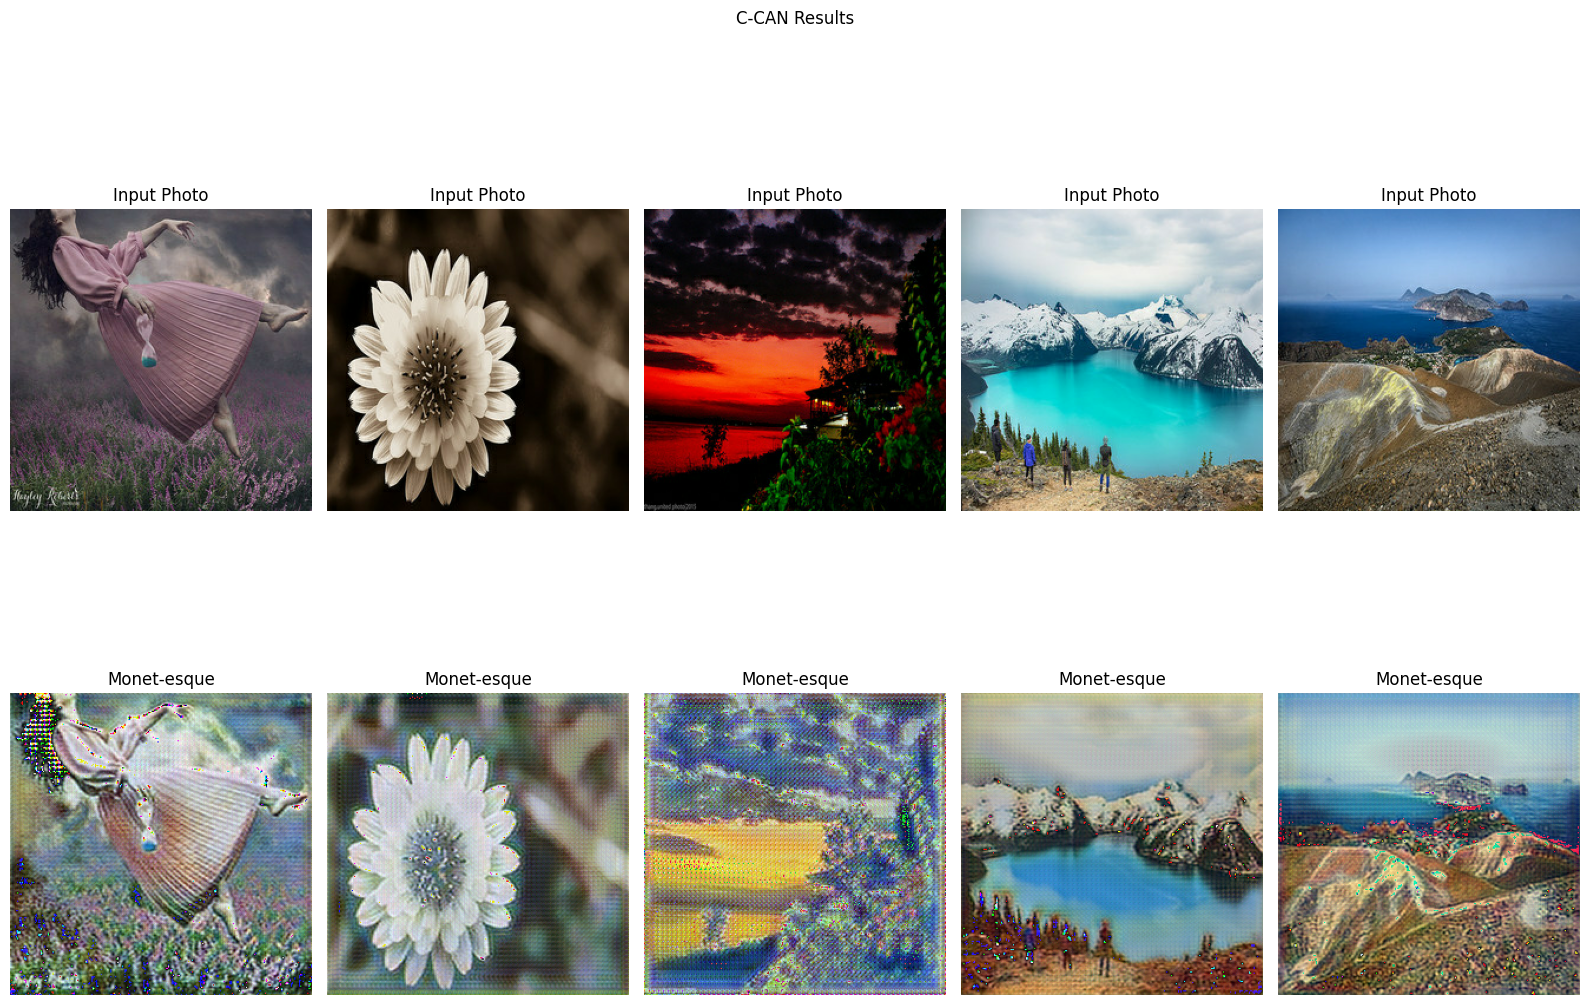

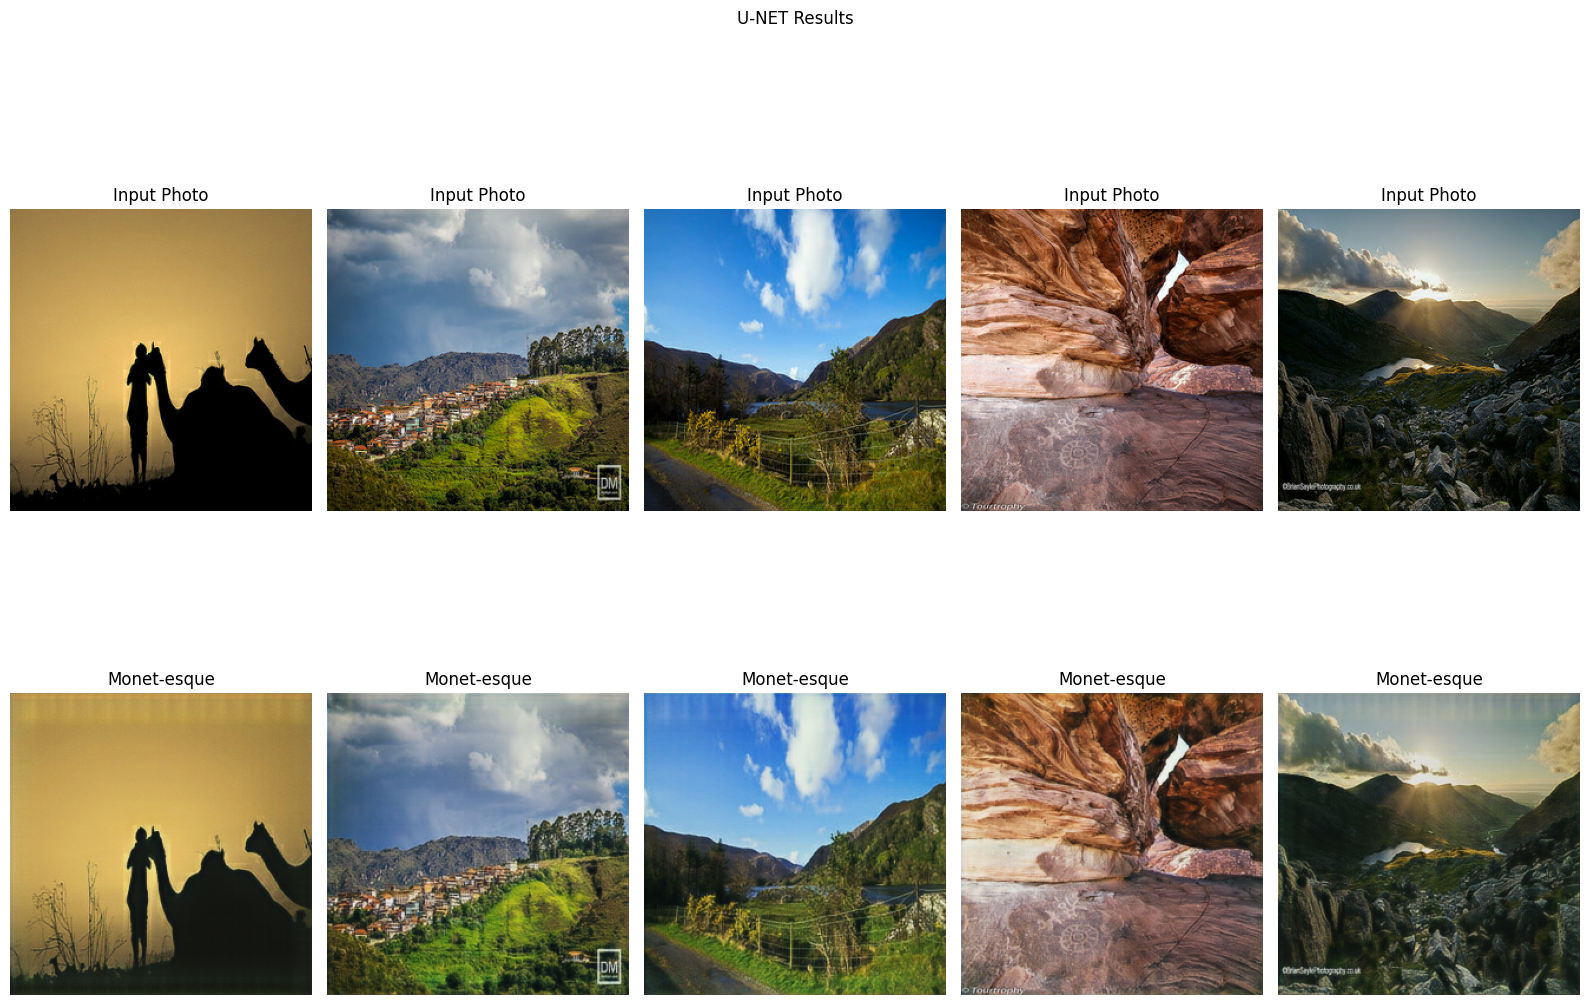

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(16, 12))
for i, img in enumerate(photos_dataset.take(5)):
    prediction = monet_ccan_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)


    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
fig.suptitle('C-CAN Results')
fig.tight_layout()

plt.show()


fig, ax = plt.subplots(2, 5, figsize=(16, 12))
for i, img in enumerate(photos_dataset.take(5)):
    prediction = monet_unet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
fig.suptitle('U-NET Results')
fig.tight_layout()

plt.show()

## Results & Conclusion:

### C-CAN:

Well right off the bat we can see that the C-CAN architecure has some nasty artifacts, and this is likely a results of what was already discussed above: A combination of the descrimnator learning too quickly, and the generator's gradients exploding/vanishing. For immediate improvement I would look to see how the gradients are behaving and prehaps introduce additional skip layers to propegate that signal forward easier. I would also want to double check that my architecture matches the one given in the paper as they had better results training for just 200 epochs. 

### U-NET:

I'm actually quite suprised by how little transformation this architecture produces. I see some visible artifacts at the top, but generally the images are mostly the same. I'm wondering if in both U-NET and C-CAN the Descriminator overfit to the data, and the only thing able to fool it was photos that are quite similar to the real ones.

Let's examine plots of the two separate losses:

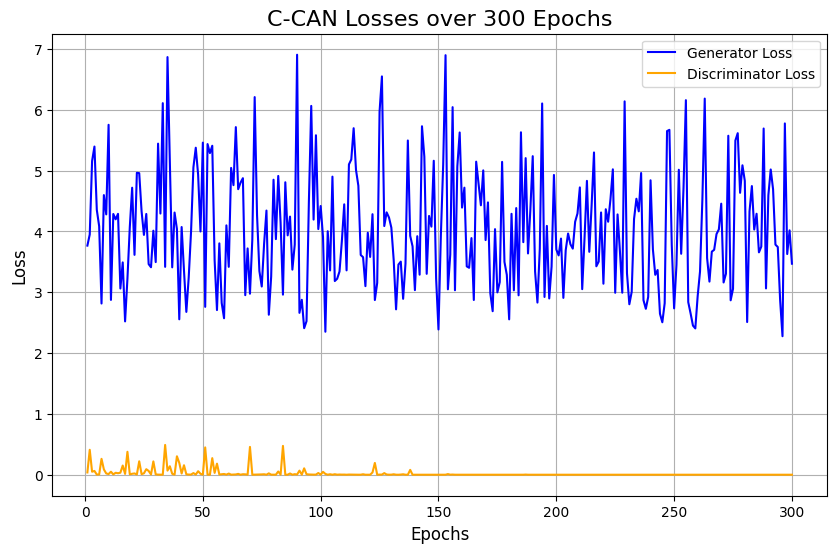

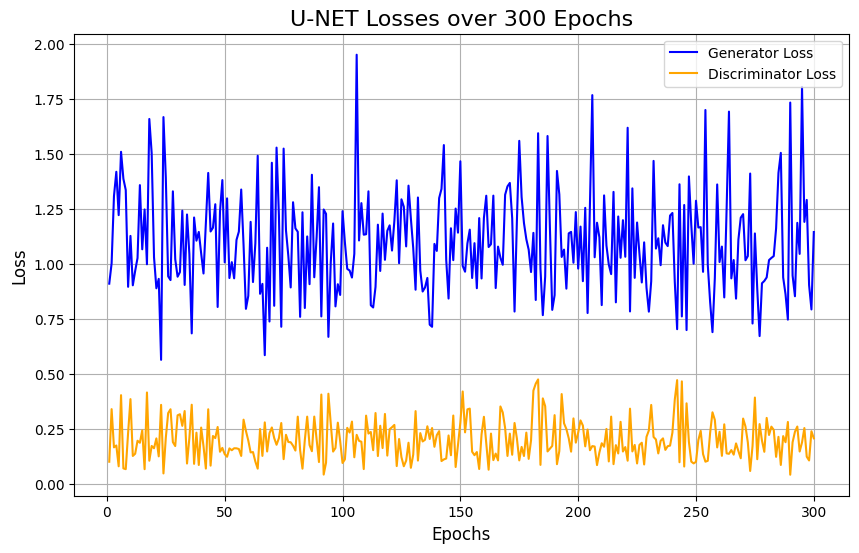

In [36]:
# Plot 1: Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 300 + 1), ccan_hist.history['monet_gen_loss'], label='Generator Loss', color='blue')
plt.plot(range(1, 300 + 1), ccan_hist.history['monet_disc_loss'], label='Discriminator Loss', color='orange')
plt.title('C-CAN Losses over 300 Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 300 + 1), unet_hist.history['monet_gen_loss'], label='Generator Loss', color='blue')
plt.plot(range(1, 300 + 1), unet_hist.history['monet_disc_loss'], label='Discriminator Loss', color='orange')
plt.title('U-NET Losses over 300 Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

The C-CAN Descriminator loss goes to zero fairly quickly, and again, is probably a big part of the reason that this architecture fails to achieve good results.

For U-NET, the learning curves actually look quite good, but the 70% discriminator accuracy as seen in the training logs hint at the fact that the discriminator was too powerful, and forced the generator to produce what is essentially the identity function to match. 

In both cases, someway to weaken the Descriminator would probably help the training. 

I will take these outputs an upload them to Kaggle just to get the score, despite my unhappiness with them.

In [37]:
output_folder = "ccan_monet_output"
os.makedirs(output_folder, exist_ok=True)

# Iterate over the entire dataset and save generated Monet-esque images
for i, img in enumerate(photos_dataset):
    # Generate Monet-esque images
    prediction = monet_ccan_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # Rescale [-1, 1] to [0, 255]

    # Save the image to the output folder
    output_path = os.path.join(output_folder, f"monet_{i}.png")
    tf.keras.preprocessing.image.save_img(output_path, prediction)

print(f"All Monet-esque images have been saved to the folder: {output_folder}")

All Monet-esque images have been saved to the folder: monet_dataset


In [ ]:
output_folder = "unet_monet_output"
os.makedirs(output_folder, exist_ok=True)

# Iterate over the entire dataset and save generated Monet-esque images
for i, img in enumerate(photos_dataset):
    # Generate Monet-esque images
    prediction = monet_unet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # Rescale [-1, 1] to [0, 255]

    # Save the image to the output folder
    output_path = os.path.join(output_folder, f"monet_{i}.png")
    tf.keras.preprocessing.image.save_img(output_path, prediction)

print(f"All Monet-esque images have been saved to the folder: {output_folder}")

I realized too late that Kaggle expects a notebook submission, rather than a file upload. This notebook has some custom imports I wasn't sure how to run on Kaggle and took overnight to run on my GPU so would be disqualified by the kaggle rules. As such, I'm going to skip deliverable 3. I think this is the same issue as the Dog Training set, ie no direct file upload. As an image for my place in the leaderboard I will submit where the file upload has been disabled. 